In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from state_space_setup import *

In [2]:
# load the necessary data created by the optimisation script
trans_prob_matrix = np.load("trans_prob_matrix.npy")
cost_matrix = np.load("cost_matrix.npy")
policy = pd.read_csv('policy.csv')

# format and extract the maximum number of parts from the loaded policy dataframe
policy['State'] = policy['State'].apply(lambda x: tuple(map(int, x.strip('()').split(','))))
maximum_parts = policy['State'].apply(lambda x: x[0]).max()
print("Maximum number of parts in the inventory:", maximum_parts)

# generate the state space
state_space = get_state_space(maximum_parts)
state_tuples = list(map(tuple, state_space))


def downtime_cost(num_parts, k=10080, lambda_=2, cost_per_week=16800):
    if num_parts == 0:
        return cost_per_week

    m = np.arange(1, k + 1)
    i = np.arange(num_parts)
    lambda_m = (lambda_ / k) * (k - m[:, None])  

    pmf = stats.poisson.pmf(i[None, :], lambda_m)
    sf = stats.poisson.sf(num_parts - i - 1, lambda_ / k)

    prob = np.sum(pmf * sf, axis=1)
    weighted_cost = prob * (m / k) * cost_per_week
    total_cost = np.sum(weighted_cost)
    normalisation = stats.poisson.sf(num_parts - 1, lambda_)

    return total_cost / normalisation


downtime_vector = np.array([downtime_cost(num_parts) for num_parts in np.arange(maximum_parts + 1)])


def cost_function(old_state, new_state, action, ordering_cost=200):
    global downtime_vector

    holding_cost_as_percentage = 0.008
    price_per_part = 100


    if action == 0:
        order_cost = 0
    else:
        order_cost = ordering_cost + price_per_part * action

    if (new_state[0] == (old_state[1] + action) and new_state[1] == 0) or (new_state[0] == 0):
        shortage_cost = downtime_vector[old_state[0]]
    else:
        shortage_cost = 0

    holding_cost = holding_cost_as_percentage * price_per_part * (max(new_state[0] - 1, 0))

    return holding_cost + order_cost + shortage_cost


def expected_action_value(current_state, action, values):
    global maximum_parts
    global cost_matrix
    global trans_prob_matrix

    discount_factor = 0.995

    current_state_idx = get_index(current_state[0], current_state[1], maximum_parts)

    probs = trans_prob_matrix[current_state_idx, :, action]
    costs = cost_matrix[current_state_idx, :, action]
    expected_value = np.dot(probs, costs + discount_factor * values)
    return expected_value

Maximum number of parts in the inventory: 41


In [3]:
ordering_costs = np.arange(0, 201, 10)
policies = np.zeros((len(ordering_costs), 2))

# Value iteration setup
error = 1e-3
values = np.zeros(len(state_space))
delta = 2 * error

In [4]:
for k, cost in enumerate(ordering_costs):
    cost_matrix = np.zeros((len(state_space), len(state_space), maximum_parts + 1))
    for i, s_old in enumerate(state_space):
        for j, s_new in enumerate(state_space):
            for a in range(maximum_parts + 1):
                cost_matrix[i, j, a] = cost_function(s_old, s_new, a, ordering_cost=cost)


    while delta >= error:
        delta = 0
        old_values = np.copy(values)
        for i, state in enumerate(state_space):
            v = values[i]
            action_space = get_action_space(state, maximum_parts)
            action_costs = np.array([
                expected_action_value(state, act, old_values)
                for act in action_space
            ])
            values[i] = np.min(action_costs)
            delta = max(delta, abs(v - values[i]))
        

    policy_records = []
    for state in state_tuples:
        action_space = get_action_space(state, maximum_parts)
        action_costs = np.array([
            expected_action_value(state, act, values)
            for act in action_space
        ])
        order = action_space[np.argmin(action_costs)]
        policy_records.append((state, order))

    policy_df = pd.DataFrame(policy_records, columns=["State", "Order_size"])
    policy_df["IP"] = policy_df["State"].apply(sum)
    policy_df["New_IP"] = policy_df["IP"] + policy_df["Order_size"]
    filtered_policy_df = policy_df[policy_df["Order_size"] != 0]
    s = filtered_policy_df["IP"].max()
    S = filtered_policy_df["New_IP"].max()
    policies[k] = [s, S]
    print(f"Iteration {k + 1}/{len(ordering_costs)} completed. For delivery cost {cost} we get, s = {s}, S = {S}")
    values = np.zeros(len(state_space))
    delta = 2 * error



    

Iteration 1/21 completed. For delivery cost 0 we get, s = 15, S = 16
Iteration 2/21 completed. For delivery cost 10 we get, s = 13, S = 19
Iteration 3/21 completed. For delivery cost 20 we get, s = 12, S = 21
Iteration 4/21 completed. For delivery cost 30 we get, s = 12, S = 22
Iteration 5/21 completed. For delivery cost 40 we get, s = 12, S = 23
Iteration 6/21 completed. For delivery cost 50 we get, s = 12, S = 25
Iteration 7/21 completed. For delivery cost 60 we get, s = 12, S = 26
Iteration 8/21 completed. For delivery cost 70 we get, s = 12, S = 27
Iteration 9/21 completed. For delivery cost 80 we get, s = 12, S = 28
Iteration 10/21 completed. For delivery cost 90 we get, s = 12, S = 28
Iteration 11/21 completed. For delivery cost 100 we get, s = 12, S = 29
Iteration 12/21 completed. For delivery cost 110 we get, s = 11, S = 30
Iteration 13/21 completed. For delivery cost 120 we get, s = 11, S = 31
Iteration 14/21 completed. For delivery cost 130 we get, s = 11, S = 32
Iteration 15

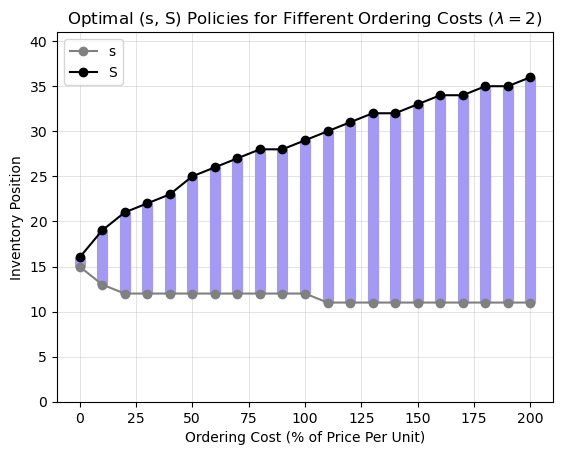

In [5]:
plt.vlines(ordering_costs, policies[:,0], policies[:,1], 
           color="#A499F4", alpha=1, linewidth=8)
plt.plot(ordering_costs, policies[:,0], "o-", label="s", color="gray")
plt.plot(ordering_costs, policies[:,1], "o-", label="S", color="black")
plt.xlabel("Ordering Cost (% of Price Per Unit)")
plt.ylabel("Inventory Position")
plt.title("Optimal (s, S) Policies for Fifferent Ordering Costs ($\\lambda=2$)")
plt.ylim(0, 41)
plt.grid(True, which="both", linestyle="-", linewidth=0.5, alpha=0.5)
plt.legend()
plt.savefig("plots/SA_ordering_cost.pdf", format="pdf", bbox_inches='tight')
plt.show()